Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [191]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers, models
from glob import glob
import Augmentor

import warnings
warnings.filterwarnings("ignore")

# Data Reading/Data Understanding

Defining the path for train and test images

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [192]:
# Importing Skin Cancer Data
# Defining the path for train and test images
curr_dir_path = pathlib.Path.cwd()
print("Current Working Directory:", curr_dir_path)

base_path = pathlib.Path(curr_dir_path)
ds_subdir = "Skin cancer ISIC The International Skin Imaging Collaboration"
path_to_training_dataset = base_path / ds_subdir / "Train"
path_to_testing_dataset = base_path / ds_subdir / "Test"

print("Training Dataset path:", path_to_training_dataset)
print("Testing Dataset path:", path_to_testing_dataset)

data_dir_train = pathlib.Path(path_to_training_dataset)
data_dir_test = pathlib.Path(path_to_testing_dataset)

Current Working Directory: /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment
Training Dataset path: /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train
Testing Dataset path: /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test


In [193]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

2239


In [194]:
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

118


In [195]:
# Define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [196]:
# Loading the training data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [197]:
# Loading the validation data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split=0.2,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb',
                                                             subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [198]:
# Loading the testing data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                             seed=123,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb')

Found 118 files belonging to 9 classes.


In [199]:
# Listing out all the classes of skin cancer and store them in a list. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Dataset visualisation

Creating a code to visualize one instance of all the nine classes present in the dataset

In [200]:
def plot_image(filenames, title=None):
    image = plt.imread(filenames)
    plt.imshow(image)
    if title:
        plt.title(title)

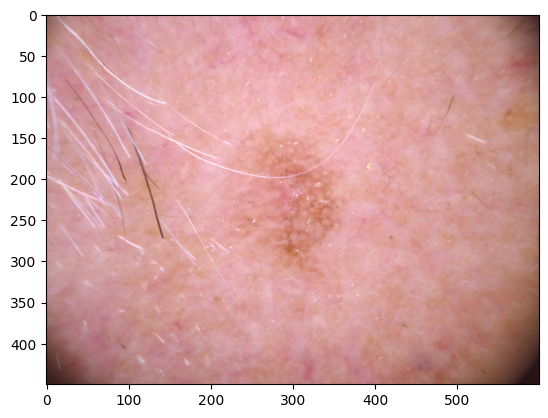

In [201]:
img_set = (list(data_dir_train.glob(class_names[0]+'/*.jpg'))[0])
plot_image(img_set)

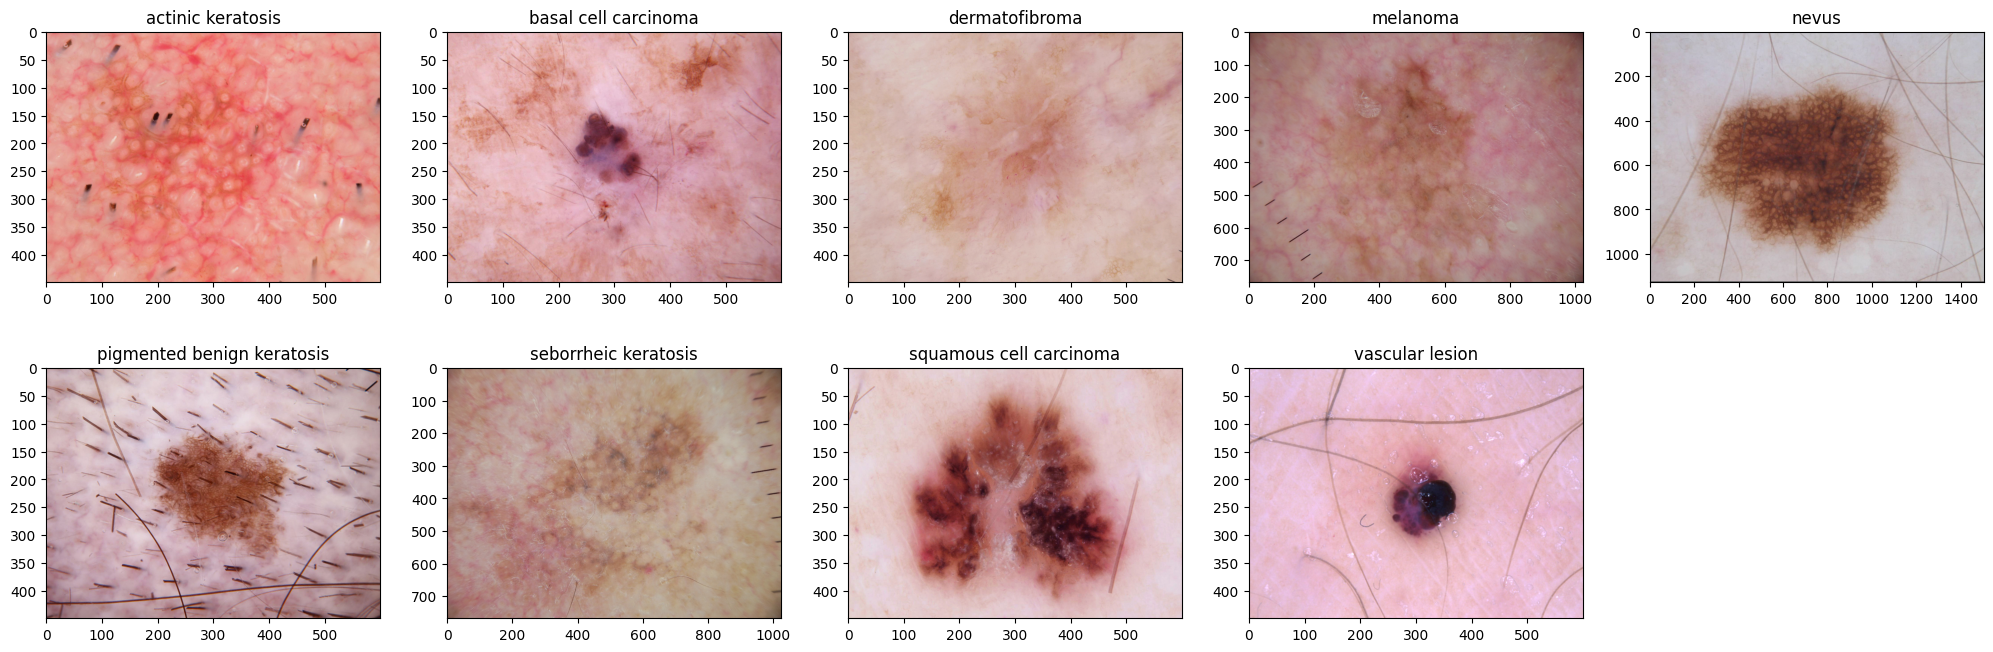

In [202]:
plt.figure(figsize=(25,8))
for i in range(len(class_names)):
  plt.subplot(2,5,i+1)
  img_name = str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1])
  plot_image(img_name, title=class_names[i])

In [203]:
# Configure the dataset for performance

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.\
# `Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [204]:
# Method to create plots of the loss and accuracy on the training and validation sets:
def plot_cnn_metrics(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Model Building & training : 

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~20 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [205]:
def create_cnn_model(data_augmentation=None, dropout_percentage=None):
    # CNN Model
    model=models.Sequential()
    # scaling the pixel values from 0-255 to 0-1
    model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

    # adding the augmentation layer before the convolution layer
    if data_augmentation:
        model.add(data_augmentation)

    # Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
    model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
    model.add(layers.MaxPooling2D())

    # Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
    model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
    model.add(layers.MaxPooling2D())

    if dropout_percentage:
        model.add(layers.Dropout(dropout_percentage))

    model.add(layers.Flatten())
    model.add(layers.Dense(256,activation='relu'))
    model.add(layers.Dense(9,activation='softmax'))
    return model

In [206]:
def compile_model(model, optimizer, loss_func, metrics):
    model.compile(optimizer=optimizer, loss=loss_func(), metrics=metrics)
    model.summary()

In [207]:
# CNN Model
model=create_cnn_model()

In [208]:
# Compiling the model
compile_model(model, 'adam', tf.keras.losses.SparseCategoricalCrossentropy, ['accuracy'])

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_17 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 259200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │    66,355,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

In [209]:
def train_model_with_epoch(epochs, train_ds, val_ds):
    return model.fit(train_ds,validation_data=val_ds,epochs=epochs)

In [210]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 360ms/step - accuracy: 0.2290 - loss: 4.4422 - val_accuracy: 0.3781 - val_loss: 1.7443
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 353ms/step - accuracy: 0.4713 - loss: 1.5335 - val_accuracy: 0.4362 - val_loss: 1.6247
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 352ms/step - accuracy: 0.5207 - loss: 1.3955 - val_accuracy: 0.4407 - val_loss: 1.5643
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 355ms/step - accuracy: 0.5788 - loss: 1.1941 - val_accuracy: 0.4855 - val_loss: 1.5133
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 352ms/step - accuracy: 0.6320 - loss: 1.0272 - val_accuracy: 0.4206 - val_loss: 1.6288
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 352ms/step - accuracy: 0.6548 - loss: 0.9771 - val_accuracy: 0.4340 - val_loss: 1.9381
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 352ms/step - accuracy: 0.6773 - loss: 0.9442 - val_accuracy: 0.4676 - val_loss: 1.7523
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.7405 - loss: 0.7380 - val_accu

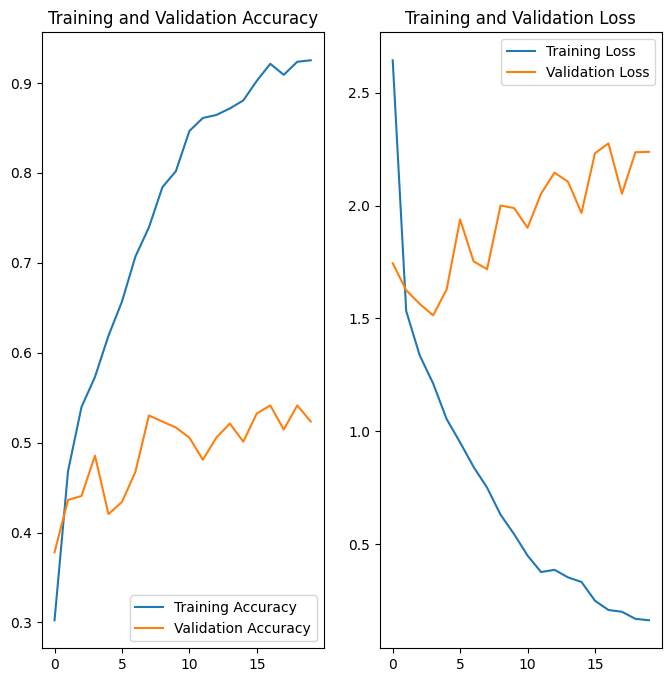

In [211]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

<b>Observations:</b>
<ol>        
<li>The model's training accuracy displays a linear increase over time, whereas the validation accuracy plateaus at 50% accuracy during the training process.
<li>As the training epochs progress, the training loss decreases, however, the validation loss exhibits an opposing trend and increases.
<li>The visual representation of the model's performance indicates a substantial discrepancy between the training accuracy and validation accuracy, achieving a validation accuracy of approximately 50%.
<li>The noticeable difference between the training accuracy and validation accuracy is a clear indication of overfitting, indicating that the model may not generalize well to unseen data.
</ol>

# Choosing an appropriate data augmentation strategy to resolve underfitting/overfitting

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [212]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

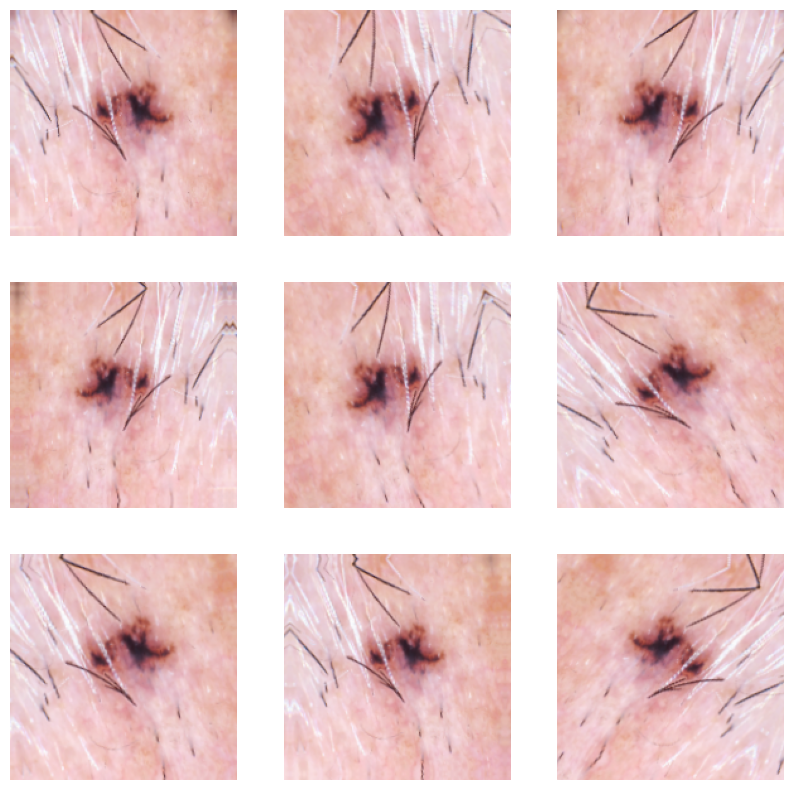

In [213]:
# visualizing how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Model Building & training on the augmented data : 

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~20 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [214]:
# CNN Model
model=create_cnn_model(data_augmentation)

In [215]:
# Compiling the model
compile_model(model, 'adam', tf.keras.losses.SparseCategoricalCrossentropy, ['accuracy'])

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_18 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_23 (Sequential)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 259200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 256)            │    66,355,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

In [216]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 363ms/step - accuracy: 0.1741 - loss: 6.8054 - val_accuracy: 0.3400 - val_loss: 1.9475
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.2601 - loss: 1.9747 - val_accuracy: 0.3647 - val_loss: 1.8549
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 356ms/step - accuracy: 0.3228 - loss: 1.8496 - val_accuracy: 0.4430 - val_loss: 1.6353
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 383ms/step - accuracy: 0.4333 - loss: 1.5939 - val_accuracy: 0.3960 - val_loss: 1.6563
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step - accuracy: 0.4712 - loss: 1.5058 - val_accuracy: 0.5101 - val_loss: 1.5304
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step - accuracy: 0.5191 - loss: 1.3932 - val_accuracy: 0.4966 - val_loss: 1.4951
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 357ms/step - accuracy: 0.5097 - loss: 1.3886 - val_accuracy: 0.5145 - val_loss: 1.4724
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 357ms/step - accuracy: 0.5091 - loss: 1.3194 - val_accu

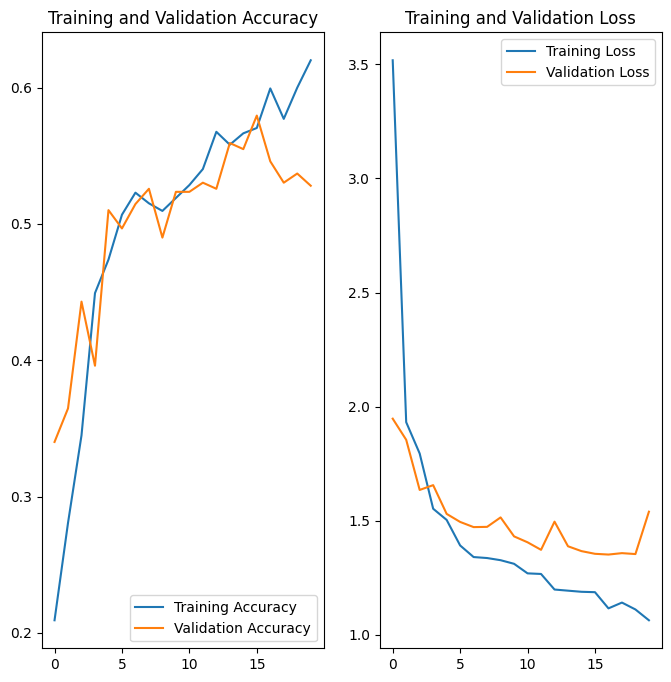

In [217]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

<b>Findings : </b>
<ol>
    <li>As the training accuracy increases linearly over time, where as the validation accuracy increases and stall at 55% accuracy in training process.</li>
    <li>As the training loss decreases with epochs the validation loss decreases and stalls.</li>
    <li>The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around <b>55%</b> accuracy on the validation set.</li>
    <li>The difference in accuracy between training and validation accuracy is still <b>slightly noticeable</b> which is a sign of overfitting.</li>
</ol>

# Model Building & training on the augmented data with dropout : 

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~20 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [218]:
#adding a 20% dropout after the convolution layers in CNN model
model = create_cnn_model(data_augmentation, dropout_percentage=0.2)

In [219]:
# Compiling the model
compile_model(model,'adam', tf.keras.losses.SparseCategoricalCrossentropy, ['accuracy'])

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_19 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_23 (Sequential)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 259200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │    66,355,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

In [220]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 365ms/step - accuracy: 0.1945 - loss: 8.0479 - val_accuracy: 0.1924 - val_loss: 2.0611
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.2185 - loss: 2.0339 - val_accuracy: 0.3624 - val_loss: 1.8530
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 362ms/step - accuracy: 0.3716 - loss: 1.7902 - val_accuracy: 0.4430 - val_loss: 1.6020
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 363ms/step - accuracy: 0.4666 - loss: 1.5300 - val_accuracy: 0.4609 - val_loss: 1.5770
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 365ms/step - accuracy: 0.4536 - loss: 1.4450 - val_accuracy: 0.5011 - val_loss: 1.4253
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 364ms/step - accuracy: 0.4812 - loss: 1.3978 - val_accuracy: 0.5391 - val_loss: 1.4021
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 364ms/step - accuracy: 0.5065 - loss: 1.3702 - val_accuracy: 0.4966 - val_loss: 1.4014
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 364ms/step - accuracy: 0.4972 - loss: 1.3544 - val_accu

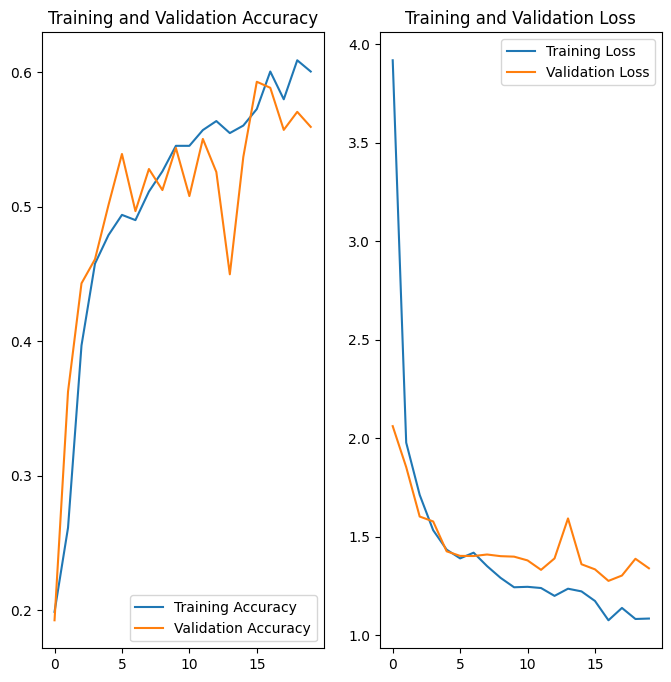

In [221]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

<b>Findings : </b>
<ol>
    <li>As the training accuracy increases linearly over time, where as the validation accuracy increases and stall at 55% accuracy in training process.</li>
    <li><b>As the training loss decreases with epochs the validation loss decreases</b></li>
    <li>The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around <b>55%</b> accuracy on the validation set.</li>
    <li>The difference in accuracy between training and validation accuracy is <b>very less</b></li>
</ol>

### **We can clearly see that the overfitting of the model has redused significantly when compared the earlier models**

# Class distribution: 

Examining the current class distribution in the training dataset

Datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. 

Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [222]:
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


<b>Findings : </b>
<ol>
    <li>Which class has the least number of samples?<br>
    <b>seborrheic keratosis with 77 samples</b></li>
    <li>Which classes dominate the data in terms proportionate number of samples?<br>
    <b>pigmented benign keratosis with 462 samples</b></li>
</ol>

# Handling class imbalances: 

Rectifing class imbalances present in the training dataset with Augmentor library.

In [223]:
for i in class_names:
    source_dir = os.path.join(curr_dir_path, ds_subdir, path_to_training_dataset.name, i)
    print("Source Directory : ", source_dir)

    output_dir = os.path.join(curr_dir_path, ds_subdir, i)
    print("Output Directory : ", output_dir)
    
    p = Augmentor.Pipeline(source_dir, output_directory=output_dir+"/")
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Source Directory :  /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis
Output Directory :  /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/actinic keratosis/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x344F9D040>: 100%|██████████| 500/500 [00:00<00:00, 695.21 Samples/s]                  


Source Directory :  /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma
Output Directory :  /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/basal cell carcinoma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x385E76180>: 100%|██████████| 500/500 [00:00<00:00, 676.85 Samples/s]                  


Source Directory :  /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma
Output Directory :  /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/dermatofibroma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16B7B18E0>: 100%|██████████| 500/500 [00:00<00:00, 637.19 Samples/s]                  


Source Directory :  /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma
Output Directory :  /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/melanoma
Initialised with 438 image(s) found.
Output directory set to /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/melanoma/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x308596BD0>: 100%|██████████| 500/500 [00:03<00:00, 146.36 Samples/s]                   


Source Directory :  /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus
Output Directory :  /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/nevus
Initialised with 357 image(s) found.
Output directory set to /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/nevus/.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x1696D2360>: 100%|██████████| 500/500 [00:03<00:00, 165.65 Samples/s]                    


Source Directory :  /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis
Output Directory :  /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/pigmented benign keratosis/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x389D34860>: 100%|██████████| 500/500 [00:00<00:00, 692.91 Samples/s]                  


Source Directory :  /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis
Output Directory :  /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/seborrheic keratosis/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x37E17F950>: 100%|██████████| 500/500 [00:01<00:00, 331.26 Samples/s]                  


Source Directory :  /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma
Output Directory :  /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/squamous cell carcinoma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x38324F860>: 100%|██████████| 500/500 [00:00<00:00, 701.77 Samples/s]                  


Source Directory :  /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion
Output Directory :  /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/vascular lesion
Initialised with 139 image(s) found.
Output directory set to /Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/Skin cancer ISIC The International Skin Imaging Collaboration/vascular lesion/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16B66A180>: 100%|██████████| 500/500 [00:00<00:00, 684.43 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [224]:
ds_dir_path = os.path.join(curr_dir_path, ds_subdir)
data_dir_train = pathlib.Path(ds_dir_path)
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [225]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [226]:
dict_new = dict(zip(path_list, lesion_list_new))
df = pd.DataFrame(list(dict_new.items()),columns = ['Path','Label'])

In [227]:
df['Label'].value_counts()

Label
melanoma                      1000
pigmented benign keratosis    1000
nevus                         1000
basal cell carcinoma          1000
actinic keratosis             1000
squamous cell carcinoma       1000
vascular lesion               1000
seborrheic keratosis          1000
dermatofibroma                1000
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [228]:
# initializing the parameter to load the images
batch_size = 32
img_height = 180
img_width = 180

In [229]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11357 files belonging to 11 classes.
Using 9086 files for training.


In [230]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11357 files belonging to 11 classes.
Using 2271 files for validation.


# Model Building & training on the rectified class imbalance data : 

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~30 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [231]:
# CNN Model
model = create_cnn_model(data_augmentation)

In [232]:
# Compiling the model
compile_model(model,'adam', tf.keras.losses.SparseCategoricalCrossentropy, ['accuracy'])

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_20 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_23 (Sequential)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 259200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 256)            │    66,355,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

In [233]:
# Training the model
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


2024-10-25 20:34:11.688509: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at sparse_xent_op.cc:103 : INVALID_ARGUMENT: Received a label value of 10 which is outside the valid range of [0, 9).  Label values: 3 1 6 7 1 1 9 3 1 3 5 4 9 6 1 7 2 1 6 4 4 10 3 3 1 9 2 2 10 1 2 9
2024-10-25 20:34:11.688525: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Received a label value of 10 which is outside the valid range of [0, 9).  Label values: 3 1 6 7 1 1 9 3 1 3 5 4 9 6 1 7 2 1 6 4 4 10 3 3 1 9 2 2 10 1 2 9
	 [[{{function_node __inference_one_step_on_data_362865}}{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]]


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/.venv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/opt/homebrew/Cellar/python@3.12/3.12.5/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/opt/homebrew/Cellar/python@3.12/3.12.5/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/base_events.py", line 1986, in _run_once

  File "/opt/homebrew/Cellar/python@3.12/3.12.5/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/.venv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/.venv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/5_/zntk1nwd65zfpzkcd8dj201m0000gq/T/ipykernel_66009/54469167.py", line 3, in <module>

  File "/Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 54, in train_step

  File "/Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/.venv/lib/python3.12/site-packages/keras/src/trainers/trainer.py", line 398, in _compute_loss

  File "/Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/.venv/lib/python3.12/site-packages/keras/src/trainers/trainer.py", line 366, in compute_loss

  File "/Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/.venv/lib/python3.12/site-packages/keras/src/trainers/compile_utils.py", line 618, in __call__

  File "/Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/.venv/lib/python3.12/site-packages/keras/src/trainers/compile_utils.py", line 659, in call

  File "/Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/.venv/lib/python3.12/site-packages/keras/src/losses/loss.py", line 60, in __call__

  File "/Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/.venv/lib/python3.12/site-packages/keras/src/losses/losses.py", line 27, in call

  File "/Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/.venv/lib/python3.12/site-packages/keras/src/losses/losses.py", line 1870, in sparse_categorical_crossentropy

  File "/Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/.venv/lib/python3.12/site-packages/keras/src/ops/nn.py", line 1559, in sparse_categorical_crossentropy

  File "/Users/rpandey1/Desktop/Upgrad/melanoma-detection-assignment/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py", line 671, in sparse_categorical_crossentropy

Received a label value of 10 which is outside the valid range of [0, 9).  Label values: 3 1 6 7 1 1 9 3 1 3 5 4 9 6 1 7 2 1 6 4 4 10 3 3 1 9 2 2 10 1 2 9
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_one_step_on_iterator_362936]

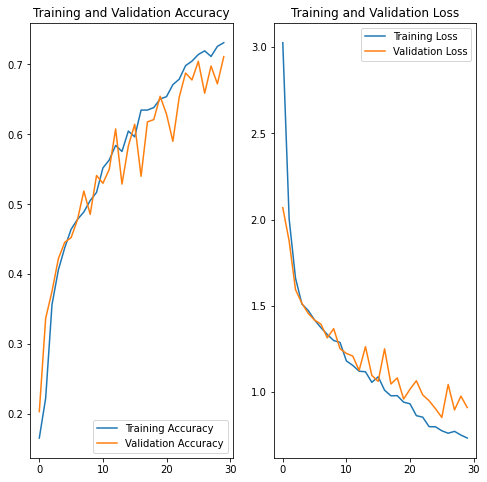

In [ ]:
# Visualizing model results
plot_cnn_metrics(history,epochs)

<b>Findings : </b>
<ol>
    <li>As the training accuracy increases linearly over time, where as the validation accuracy increases in training process.</li>
    <li>As the training loss decreases with epochs the validation loss also decreases.</li>
    <li>The plots show that gap between training accuracy and validation accuracy have decreased significantly from previous model, and it has achieved around <b>75%</b> accuracy on the validation set.</li>
    <li>The difference in accuracy between training and validation accuracy is <b>very less</b></li>
</ol>

<h4>Class rebalancing not only got rid of overfitting it also improved the accuracy from 55% to 75%.</h4>  